In [1]:
import numpy as np
import pandas as pd

from astropy.io import fits

import matplotlib.pyplot as plt

# import thecannon as tc
# from thecannon import continuum

In [2]:
ROOT = 'C:/Users/Kirsten Banks/'
RAW_DATA = ROOT+'OneDrive - UNSW/Projects/Xshooter/USEFUL/'
NORM_PATH = ROOT+'OneDrive - UNSW/Projects/Xshooter/NORMALISED/'
SINGLE_PATH = ROOT+'OneDrive - UNSW/Projects/Xshooter/SINGLE_NORM/'
files = pd.read_csv(ROOT+'OneDrive - UNSW/Projects/Xshooter/fileNames.csv')
norm_files = pd.read_csv(ROOT+'OneDrive - UNSW/Projects/Xshooter/normalised_files.csv')

In [ ]:
def extract_data(file,path=RAW_DATA,scale=True):
    """Pull spectral information out of raw fits file.
    Returns: wavelength, flux, error"""
    with fits.open(path+file) as data:
        w0 = data[0].header['CRVAL1']
        dw = data[0].header['CDELT1']
        f = data[0].data
        e = data[1].data
        
    w = [np.round(w0+dw*i,2) for i in range(len(f))]
    
    if scale:
        f = (f*1e13)
        e = (e*1e13)
    
    return np.array(w), np.array(f), np.array(e)

def filter_NIR(x):
    if (x<=1020):
        return False
    elif (x>1100) & (x<1175):
        return False
    elif (x>1330) & (x<1460):
        return False
    elif (x>1800) & (x<1950):
        return False
    elif (x>2400):
        return False
    else:
        return True
    
def filter_UVB(x):
    if (x<350):
        return False
    elif (x>540):
        return False
    else:
        return True

def filter_VIS(x):
    if (x<580):
        return False
    else:
        return True
    
def normalise(file,N=50,save=True,out=True):
    # load in data
    w,f,e = extract_data(file)
    
    # note down star id, arm and set mask (based on arm)
    star_id = file.split("_")[0]
    
    if "NIR" in file:
        arm = "NIR"
        mask = list(map(filter_NIR, w))
    elif "VIS" in file:
        arm = "VIS"
        mask = list(map(filter_VIS, w))
    elif "UVB" in file:
        arm = "UVB"
        mask = list(map(filter_UVB, w))
    
    # do split and determine array for interpolation
    w_split = np.array_split(w[mask],N)
    f_split = np.array_split(f[mask],N)

    y = [np.quantile(i,0.95) for i in f_split]
    y.insert(0,f[mask][0])
    y.append(f[mask][-1])

    x = [np.mean(i) for i in w_split]
    x.insert(0,w[mask][0])
    x.append(w[mask][-1])
    
    # do interpolation
    fit = interp1d(x,y)
    
    # normalised flux and errors
    norm_f = f[mask]/fit(w[mask])
    norm_e = e[mask]/fit(w[mask])
    
    if save:
        hdu0 = fits.PrimaryHDU(w[mask])
        hdu1 = fits.ImageHDU(norm_f)
        hdu2 = fits.ImageHDU(norm_e)

        hdul = fits.HDUList([hdu0,hdu1,hdu2])

        try:
            hdul.writeto(NORM_PATH+star_id+'_'+arm+'_norm.fits')
        except:
            print("File already exists...")
    
    if out:
        return w[mask],norm_f,norm_e

In [ ]:
"""DON'T NEED TO RUN AGAIN"""
# for i in files['fileName']:
#     normalise(i,out=False)

In [ ]:
files.head(3)

In [ ]:
w_UVB,f_UVB,e_UVB = extract_data(files['fileName'][1])
w_VIS,f_VIS,e_VIS = extract_data(files['fileName'][2])
w_NIR,f_NIR,e_NIR = extract_data(files['fileName'][0])

UVB_MASK = list(map(filter_UVB, w_UVB))
VIS_MASK = list(map(filter_VIS, w_VIS))
NIR_MASK = list(map(filter_NIR, w_NIR))

star_id = files['fileName'][0].split("_")[0]

In [ ]:
# Determine local maxima in sections of masked spectra
N = 50
w = w_NIR
f = f_NIR
m = NIR_MASK
arm = "NIR"

w_split = np.array_split(w[m],N)
f_split = np.array_split(f[m],N)

y = [np.quantile(i,0.95) for i in f_split]
y.insert(0,f[m][0])
y.append(f[m][-1])

# x = [w_split[i][np.where(f_split[i]==y[i])[0][0]] for i in range(N)]
x = [np.mean(i) for i in w_split]
x.insert(0,w[m][0])
x.append(w[m][-1])

In [ ]:
from scipy.interpolate import interp1d
fit = interp1d(x,y)

In [ ]:
# UVB closer look
plt.plot(w[m],f[m])
plt.scatter(x,y,c='k',zorder=3)
plt.plot(w[m],fit(w[m]))


# plt.xlim(1450,1810)
plt.ylim(0,1)

In [ ]:
plt.plot(w[m],f[m]/fit(w[m]))
plt.ylim(0,1.2);

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)

ax[0].plot(w[m],f[m],label='flux')
ax[0].scatter(x,y,c='k',s=20,zorder=4,label='quantiles')
ax[0].plot(w[m],fit(w[m]),zorder=3,label='fit')
ax[0].legend(fontsize=12)
ax[0].set_ylim(0,1.2)

ax[1].plot(w[m],f[m]/fit(w[m]),label='normalised')
ax[1].legend(fontsize=12)
ax[1].set_ylim(0,1.2)

for i in ax:
    i.set_xlabel('Wavelength [nm]',fontsize=12)

fig.suptitle(f"{star_id}: {arm}",y=0.95,fontsize=14)
fig.subplots_adjust(wspace=0)
# fig.savefig(f"./norm_ex_{arm}.jpg",bbox_inches='tight',pad_inches=0.1)

### Merge arms together into single spectrum

In [ ]:
stars = list(set([i.split("_")[0] for i in norm_files['fileName']]))
norm_files['ID'] = [i.split("_")[0] for i in norm_files['fileName']]

# for j in stars:
#     s = j
#     files = norm_files[norm_files['ID']==s]

#     for i in files['fileName']:
#         if "NIR" in i:
#             with fits.open(NORM_PATH+i) as data:
#                 w_NIR = data[0].data
#                 f_NIR = data[1].data
#                 e_NIR = data[2].data
#         elif "VIS" in i:
#             with fits.open(NORM_PATH+i) as data:
#                 w_VIS = data[0].data
#                 f_VIS = data[1].data
#                 e_VIS = data[2].data
#         elif "UVB" in i:
#             with fits.open(NORM_PATH+i) as data:
#                 w_UVB = data[0].data
#                 f_UVB = data[1].data
#                 e_UVB = data[2].data

#     w = np.concatenate([w_UVB,w_VIS,w_NIR])
#     f = np.concatenate([f_UVB,f_VIS,f_NIR])
#     e = np.concatenate([e_UVB,e_VIS,e_NIR])

#     hdu0 = fits.PrimaryHDU(w)
#     hdu1 = fits.ImageHDU(f)
#     hdu2 = fits.ImageHDU(e)

#     hdul = fits.HDUList([hdu0,hdu1,hdu2])

#     try:
#         hdul.writeto(SINGLE_PATH+s+'.fits')
#     except:
#         print("File already exists...")

In [ ]:
# plt.plot(w_UVB,f_UVB)
# plt.plot(w_VIS,f_VIS)
# plt.plot(w_NIR,f_NIR)

plt.plot(w,f)

# The Cannon stuff
#### Version 0.5.6

In [ ]:
# import thecannon as tc
from thecannon import dataset

from astropy.table import Table

In [ ]:
# load labels
# labels_table = Table.read('./Cannon/X-Shooter stars_ stellar parameters - KB Sheet.csv',)
labels_table = Table.read('/Users/z5059656/OneDrive - UNSW/Projects/Xshooter/Cannon/X-Shooter stars_ stellar parameters - KB Sheet.csv',)
df_labels = labels_table.to_pandas()
stars = df_labels['EPIC-ID'].values

# normalised files list
# norm_files = pd.read_csv('./normalised_files.csv')
norm_files = pd.read_csv('/Users/z5059656/OneDrive - UNSW/Projects/Xshooter/normalised_files.csv')

#### Looking at label space

In [ ]:
# pd.plotting.scatter_matrix(df_labels[['Teff','logg_seis','Fe/H','dnu','nu_max']],alpha=1,figsize=(15,15)); 
df_labels.sort_values(by='Kmag')

### TheCannon 0.5.6

In [ ]:
from thecannon import dataset

In [ ]:
# WHAT ARM????
arm = "UVB"

# train_labels = labels_table['Teff','logg_seis','Fe/H','dnu','nu_max'] # astropy table
train_labels = df_labels[['Teff','logg_seis','Fe/H','dnu','nu_max']].values

# load data
train_flux = []
train_ivar = []
train_ID = []

for i in norm_files['fileName']:
    if arm in i:
        train_ID.append(i.split("_")[0])
        with fits.open(NORM_PATH+i) as data:
            wav = data[0].data.astype(float)
            train_flux.append(data[1].data.astype(float))
            train_ivar.append(1/(data[2].data.astype(float)**2))
            
train_flux = np.array(train_flux).astype(float)
train_ivar = np.array(train_ivar).astype(float)
train_ID = np.array(train_ID)

# train_flux = train_flux
# train_ivar = train_ivar
# train_ID = train_ID

In [ ]:
# SINGLE SPECTRA

# train_labels = labels_table['Teff','logg_seis','Fe/H','dnu','nu_max'] # astropy table
train_labels = df_labels[['Teff','logg_seis','Fe/H','dnu','nu_max']].values

# load data
train_flux = []
train_ivar = []
train_ID = []

for i in stars:
    train_ID.append(i)
    with fits.open(SINGLE_PATH+i+'.fits') as data:
        wav = data[0].data.astype(float)
        train_flux.append(data[1].data.astype(float))
#         train_ivar.append(1/(data[2].data.astype(float))**2)
#         train_ivar.append(data[2].data.astype(float))
        train_ivar.append(np.ones(len(data[1].data.astype(float)))*1e4)
            
train_flux = np.array(train_flux).astype(float)
# train_ivar = np.array([1/i**(2) for i in train_ivar])
train_ivar = np.array(train_ivar).astype(float)
train_ID = np.array(train_ID)

# train_flux = train_flux
# train_ivar = train_ivar
# train_ID = train_ID

In [ ]:
ds = dataset.Dataset(wav,train_ID, train_flux, train_ivar, train_labels, train_ID, train_flux, train_ivar)

In [ ]:
plt.hist(1/(ds.test_ivar[0])**2)

In [ ]:
plt.plot(ds.wl,ds.test_flux[0])
plt.plot(ds.wl,ds.test_ivar[0])
plt.xlim(1450,1600)
plt.ylim(0,1.2)

In [ ]:
# ds.set_label_names(["Teff","logg","[Fe/H]","\delta\nu","\nu_{max}"])
ds.set_label_names(["Teff","logg","[Fe/H]","\delta\\nu","\\nu_{max}"])

In [ ]:
# for i in train_ivar:
#     try:
#         1/i**2
#     except:
#         print("ERROR")

ivar = [1/i**2 for i in train_ivar]

In [ ]:
fig = ds.diagnostics_SNR()
# fig.savefig(f"./{arm}_diagnostics_SNR.jpg")
fig.savefig(f"./diagnostics_SNR.jpg")

In [ ]:
fig = ds.diagnostics_ref_labels()
# fig.savefig(f"./{arm}_diagnostics_ref_labels.jpg")

In [ ]:
pseudo_tr_flux, pseudo_tr_ivar = ds.continuum_normalize_training_q(q=0.90, delta_lambda=50)

In [ ]:
contmask = ds.make_contmask(pseudo_tr_flux,pseudo_tr_ivar, frac=0.07)

In [ ]:
plt.plot(ds.wl,ds.tr_flux[0],label='spectrum')
plt.scatter(ds.wl[contmask],ds.tr_flux[0][contmask],c='k',zorder=3,s=5,label='continuum pixels')
plt.ylim(0,1.2)
# plt.savefig(f"./{arm}_spectrum_continuum_pixels.jpg")
plt.savefig(f"./spectrum_continuum_pixels.jpg")

In [ ]:
ds.set_continuum(contmask)

In [ ]:
cont = ds.fit_continuum(3, "sinusoid")

In [ ]:
norm_tr_flux, norm_tr_ivar, norm_test_flux, norm_test_ivar = ds.continuum_normalize(cont)

In [ ]:
plt.plot(ds.wl, norm_tr_flux[16,:])

In [ ]:
ds.tr_flux = norm_tr_flux
ds.tr_ivar = norm_tr_ivar
ds.test_flux = norm_test_flux
ds.test_ivar = norm_test_ivar

In [ ]:
p = md.coeffs

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(ds.wl,p[:,1])
plt.plot(ds.wl,p[:,0])
# plt.ylim(-0.002,0.002)

In [ ]:
# ACTUALLY RUNNING THE CANNON NOW
from thecannon import model
md = model.CannonModel(2)
md.fit(ds)

In [ ]:
ds.get_plotting_labels()

In [ ]:
# md.diagnostics_contpix(ds,fig=f"{arm}_basline_spec_with_cont_pix")
md.diagnostics_contpix(ds)
md.diagnostics_leading_coeffs(ds)
# md.diagnostics_plot_chisq(ds,figname=f"{arm}_modelfit_chisqs.png")
md.diagnostics_plot_chisq(ds)

In [ ]:
label_errs = md.infer_labels(ds)

In [ ]:
test_labels = ds.test_label_vals

In [ ]:
ds.diagnostics_test_step_flagstars()
ds.diagnostics_survey_labels()

In [ ]:
# ds.diagnostics_1to1(figname=f"{arm}_1to1_label")
ds.diagnostics_1to1()

## Other TheCannon method

In [ ]:
# short_labels = labels_table[['Teff','logg_seis','Fe/H','dnu','nu_max']] # definitely in the same order as the flux and ivar arrays
train_labels = labels_table['Teff','logg_seis','Fe/H','dnu','nu_max']

# [labels_table['Teff'].values,labels_table['logg_seis'].values,labels_table['Fe/H'].values]#,labels_table['dnu'].values,labels_table['nu_max'].values]
label_names = ("Teff","logg_seis","Fe/H","dnu","nu_max")

In [ ]:
# load data
train_flux = []
train_ivar = []

for i in norm_files['fileName']:
    if "VIS" in i:
        with fits.open(NORM_PATH+i) as data:
            wav = data[0].data
            train_flux.append(data[1].data)
            train_ivar.append(data[2].data)
            
train_flux = np.array(train_flux)
train_ivar = np.array(train_ivar)

In [ ]:
model = tc.CannonModel(train_labels,train_flux,train_ivar,tc.vectorizer.PolynomialVectorizer(label_names,2),dispersion=wav)

In [ ]:
print(model.vectorizer.human_readable_label_vector)

In [ ]:
print(model.regularization)

In [ ]:
print(model.censors)

In [ ]:
theta, s2, metadata = model.train(threads=1)

In [ ]:
fig_scatter = tc.plot.scatter(model)

In [ ]:
import seaborn as sns

In [ ]:
sns.heatmap(data=theta)

In [ ]:
theta.shape

In [ ]:
df_labels = labels_table.to_pandas()

In [ ]:
print("new_type")
print(f"RC: {df_labels[df_labels['new_type']=='RC'].shape[0]}, RGB: {df_labels[df_labels['new_type']=='RGB'].shape[0]}")
print("\ntype")
print(f"RC: {df_labels[df_labels['type']=='RC'].shape[0]}, RGB: {df_labels[df_labels['type']=='RGB'].shape[0]}")

# Sven's Tutorial
#### The Cannon 0.2.93

In [122]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.io import fits
import numpy as np
from astropy.table import Table, join
from scipy.io.idl import readsav
# from astropy.io.fits import pyfits
import matplotlib.pyplot as plt
import pickle
import thecannon as tc
import pandas as pd

In [124]:
# Setting up the labels
df_train = pd.read_csv(ROOT+'/OneDrive - UNSW/Projects/Xshooter/Cannon/parameters.csv',nrows=50)
stars = df_train['EPIC-ID'].values
df_train = df_train.rename(columns={'Fe/H': 'fe_h'})
trainingset = Table.from_pandas(df_train)

print(trainingset.keys())

labels = tuple(['Teff','logg_seis','fe_h','dnu'])

training_set_labels = Table()
for label in labels:
    training_set_labels[label] = trainingset[label]
    
# training_set_labels

['EPIC-ID', 'Gaia ID', '2MASS ID', 'RA', 'DEC', 'Kmag', 'Teff', 'logg_seis', 'logg_spec', 'fe_h', 'Fe/H_seis', 'Mass', 'nu_max', 'dnu', 'dnu_prob', 'type', 'new_type', 'type_change']


In [126]:
# Setting up the wavelength
with fits.open(SINGLE_PATH+stars[0]+'.fits') as data:
    wavelength_array = data[0].data

len(wavelength_array)

48586

In [141]:
# Setting up flux and ivar arrays
fluxes = []
sigmas = []

for i in stars:
    with fits.open(SINGLE_PATH+i+'.fits') as data:
        fluxes.append(list(data[1].data))
        sigmas.append(list(data[2].data))
        
fluxes = np.array(fluxes)
sigmas = np.array(sigmas)

if fluxes.shape == sigmas.shape:
    print(f"Flux and error are the same shape {fluxes.shape}")
else:
    print(f"Flux and error are NOT the same shape")

Flux and error are the same shape (50, 48586)


In [148]:
# Make sure we don't use any pixels with flux < 0
useful_flux_sigma = ((fluxes > 0) & (sigmas > 0))

fluxes[~useful_flux_sigma] = 1.0
sigmas[~useful_flux_sigma] = 1000

# define correct ivar
ivars = 1./sigmas**2

In [152]:
# Some pixles have no useful entry - let's get rid of them
useful_wavelength = np.all(useful_flux_sigma,axis=0)

# Reduce wavelength, flux and ivar values to those usefel pixels
wave = wavelength_array[useful_wavelength]
flux = fluxes[:,useful_wavelength]
ivar = ivars[:,useful_wavelength]

wave.shape,flux.shape,ivar.shape

((48093,), (50, 48093), (50, 48093))

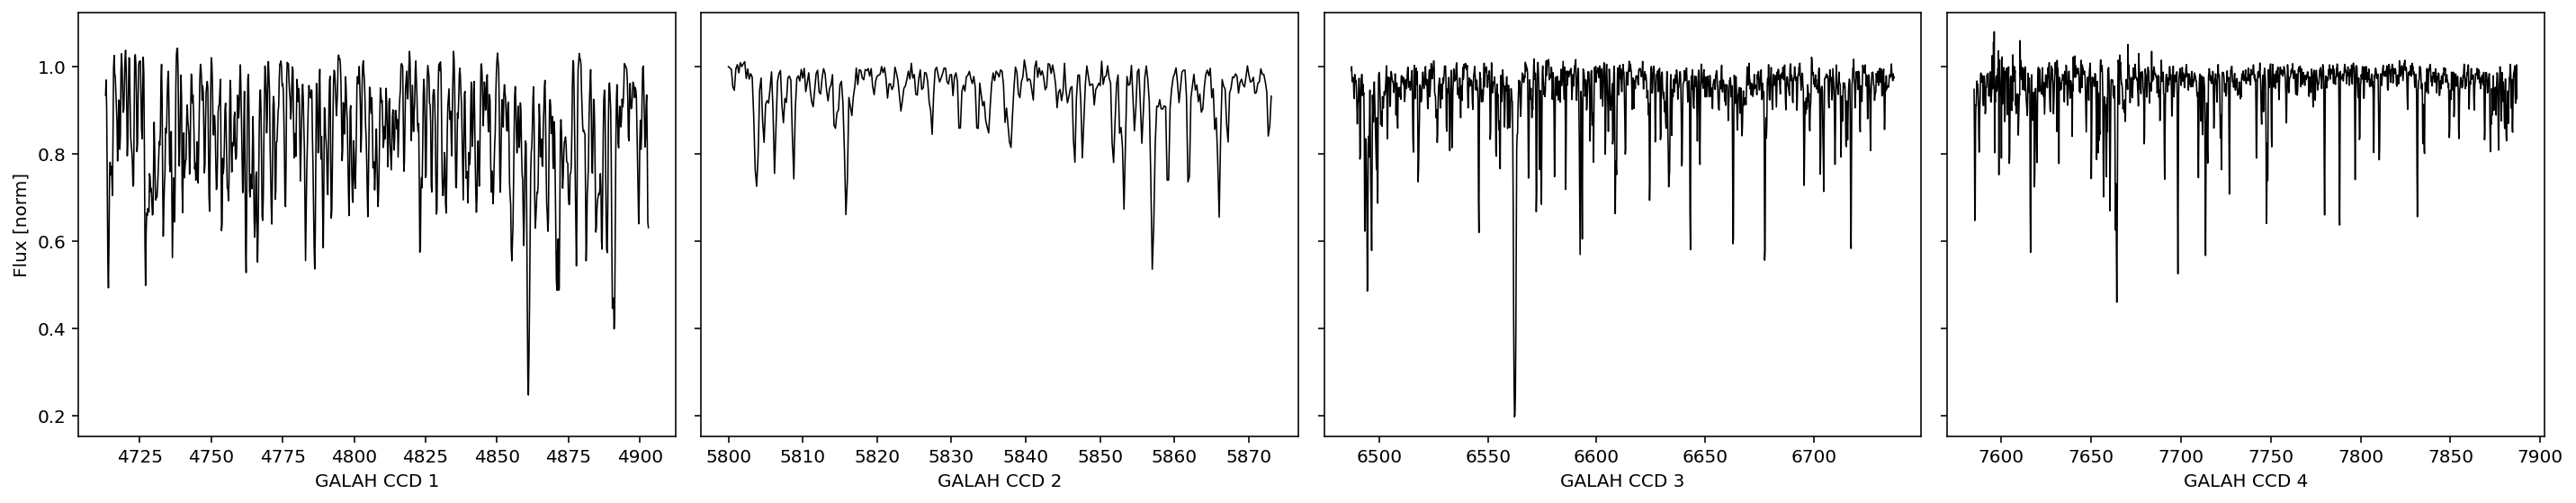

In [153]:
# plot equivalent galah regions
galah = [(471.3,490.3),(564.8,587.3),(648.7,673.7),(758.5,788.7)]

fig, ax = plt.subplots(1,4,figsize=(20,4),sharey=True)

for i in range(4):
    in_wavelength_range = (wave >= galah[i][0]) & (wave <= galah[i][1])
    ax[i].plot(wave[in_wavelength_range]*10,flux[0][in_wavelength_range],
              lw=0.8,c='k')
    ax[i].set_xlabel(f'GALAH CCD {i+1}')
    
    if i == 0:
        ax[i].set_ylabel('Flux [norm]')
    
plt.tight_layout()

### Setting up, Training, and Testing The Cannon

In [154]:
# We can use a linear, quadratic, etc. model. A quadratic one has order 2
order = 2

model_file = 'xshooter_model_order'+str(order)+'_'+"_".join(labels)

# Now if we have already trained the Cannon, we can simply read in the existing Model
try:
    model = tc.CannonModel.read(model_file+'.model')
    print('Model already exists')
except:
    # There is no Cannon model available yet
    # Let's set up the Cannon model
    print('Setting up Cannon Model')
    model = tc.CannonModel(
        training_set_labels, flux, ivar,
        vectorizer=tc.vectorizer.PolynomialVectorizer(labels, order),dispersion=wave)

Setting up Cannon Model


In [155]:
# This is where the magic happens! We train the Cannon (if it is not yet trained)!

# This will start with several "red" messages. 
# A common warning is "Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH"
# Don't panic - that just means it will take a different optimisation algorithm than the default one.

if not model.is_trained:
    print('Training The Cannon')
    theta, s2, metadata = model.train(threads=1)
    
    # Save the result
    model.write(model_file+'.model', overwrite=True, include_training_set_spectra=True)
else:
    print('The Cannon is already trained')
    
# Now let's run the Cannon on its own training set to estimate labels and uncertainties
print('Testing The Cannon')
test_labels, cov, metadata = model.test(flux, ivar)

2022-02-17 09:27:39,913 [INFO] Training 4-label CannonModel with 50 stars and 48093 pixels/star
2022-02-17 09:27:39,935 [DEBUG] Couldn't get screen size. Progressbar may look odd.


Training The Cannon
[====================================================================================================] 100% (220s)                                 
Testing The Cannon

2022-02-17 09:31:19,846 [DEBUG] Couldn't get screen size. Progressbar may look odd.


2022-02-17 09:31:19,846 [INFO] Running test step on 50 spectra


[==================================================                                                  ] 100% (10s)                            


In [179]:
snr = [i['snr'] for i in metadata]

(array([1., 1., 1., 6., 7., 8., 9., 9., 7., 1.]),
 array([33.19582956, 35.96372789, 38.73162623, 41.49952456, 44.2674229 ,
        47.03532123, 49.80321957, 52.5711179 , 55.33901624, 58.10691457,
        60.8748129 ]),
 <BarContainer object of 10 artists>)

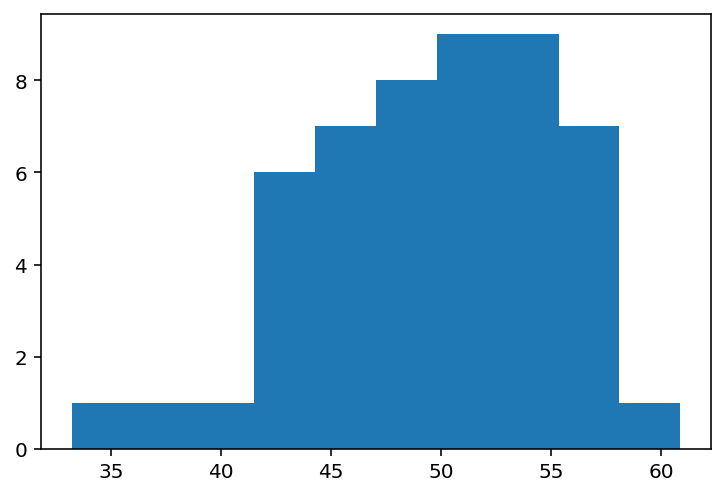

In [183]:
plt.hist(snr)

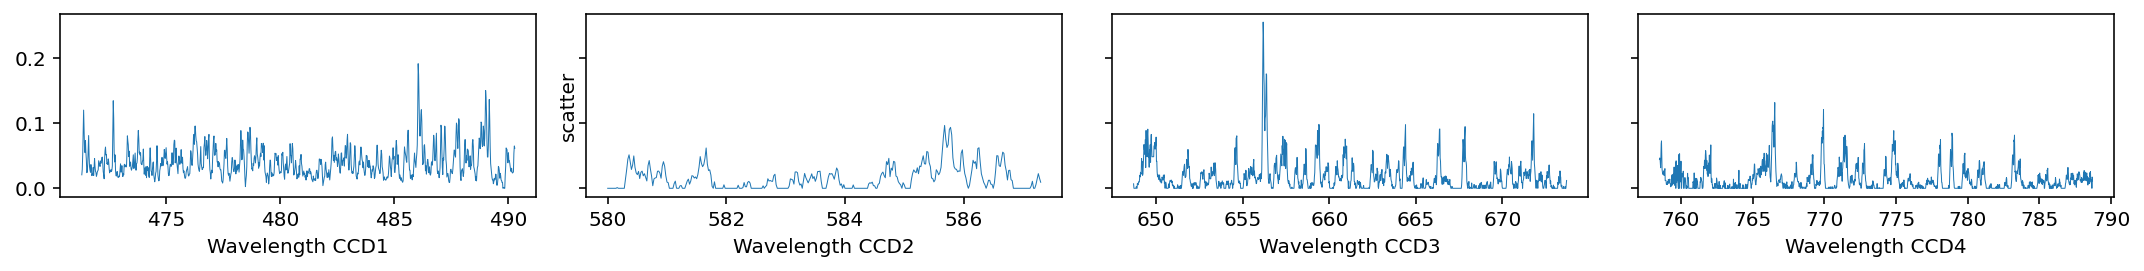

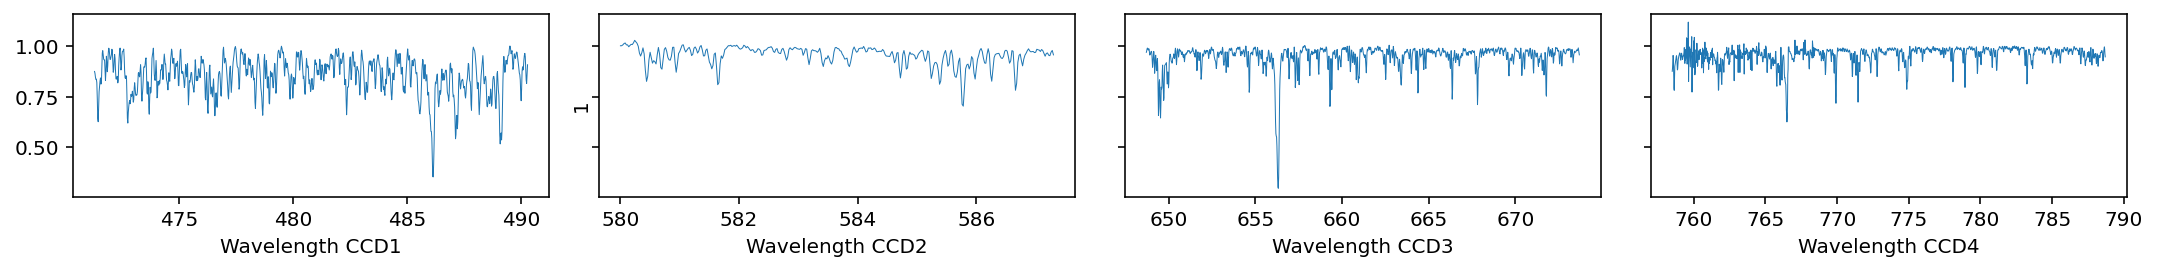

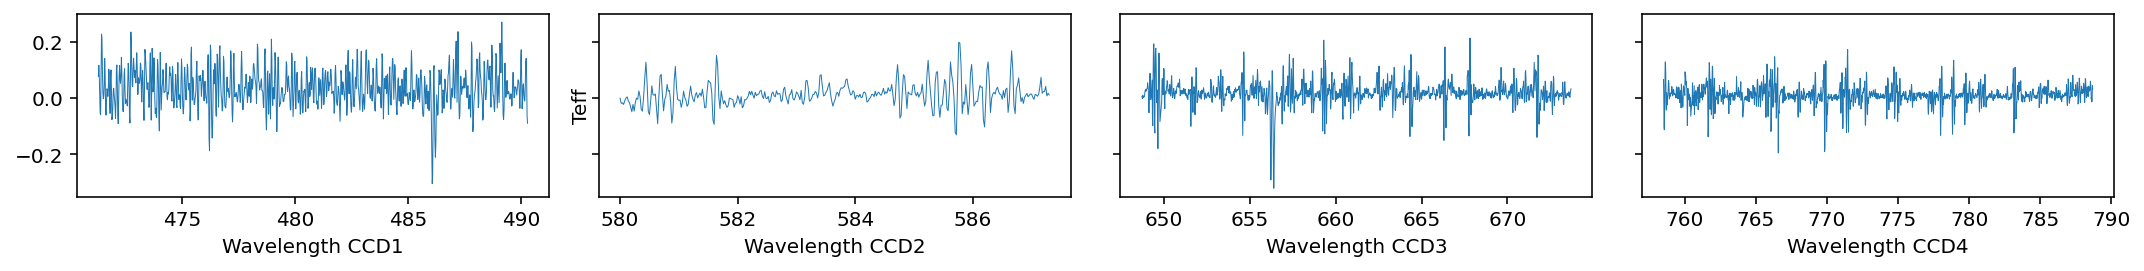

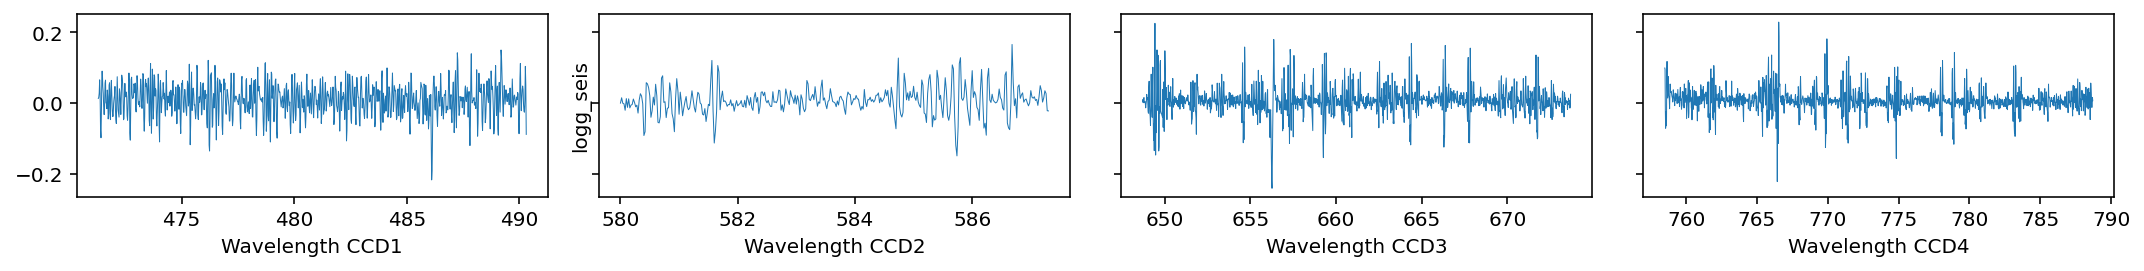

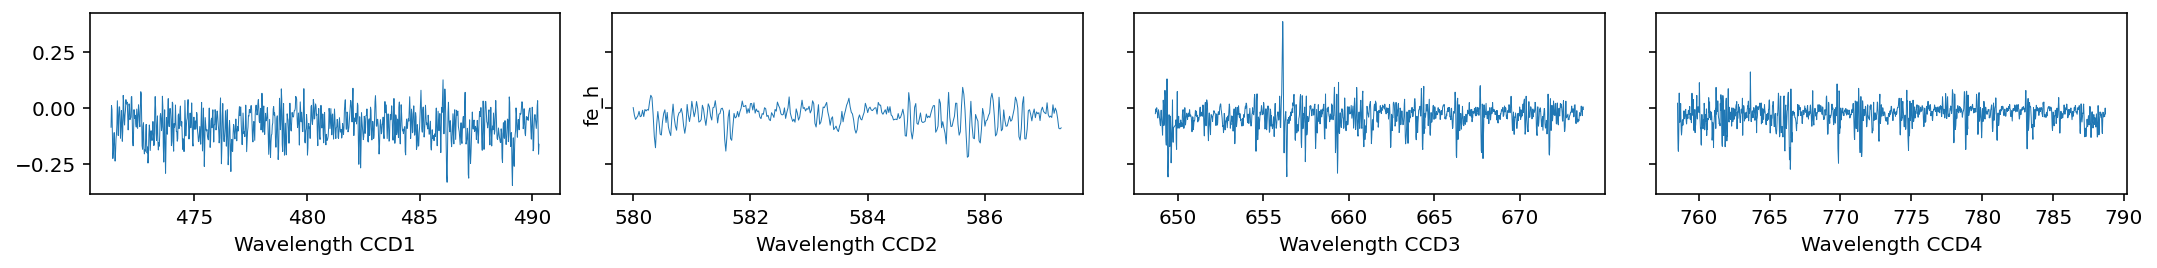

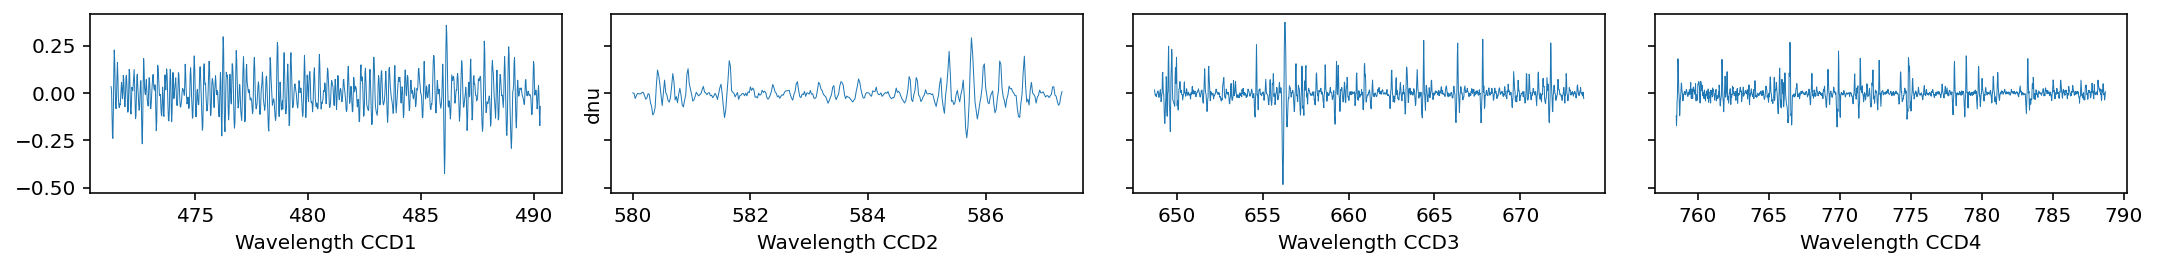

In [156]:
# Plot coefficients

def plot_coefficients(model, index, ccds=galah, wavelength_array = None):
    
    if index == -1:
        ylabel = 'scatter'
    else:
        ylabel = model.vectorizer.get_human_readable_label_term(index,
                    label_names = model.vectorizer.label_names, mul='\cdot', pow='^')
        
    f, gs = plt.subplots(1,len(ccds),figsize=(15,2),sharey=True)
    
    for i in range(len(ccds)):
        ax = gs[i]
        
        in_wavelength_range = (wavelength_array >= ccds[i][0]) & (wavelength_array <= ccds[i][1])
        
        if index == -1:
            ax.plot(
                wavelength_array[in_wavelength_range],
                model.s2[in_wavelength_range]**0.5,
                lw=0.5,c='C0'
            )
        else:
            ax.plot(
                wavelength_array[in_wavelength_range],
                model.theta[in_wavelength_range,index],
                lw=0.5,c='C0',label='TheCannon'
            )
        ax.set_xlabel('Wavelength CCD'+str(i+1))
        
        if i==1:
            ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.savefig('coefficient_plots/coeff_'+model_file+'_'+ylabel+'.png',dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()
    
for index in range(-1,len(labels)+1):
    plot_coefficients(model, index, ccds=galah, wavelength_array=wave)

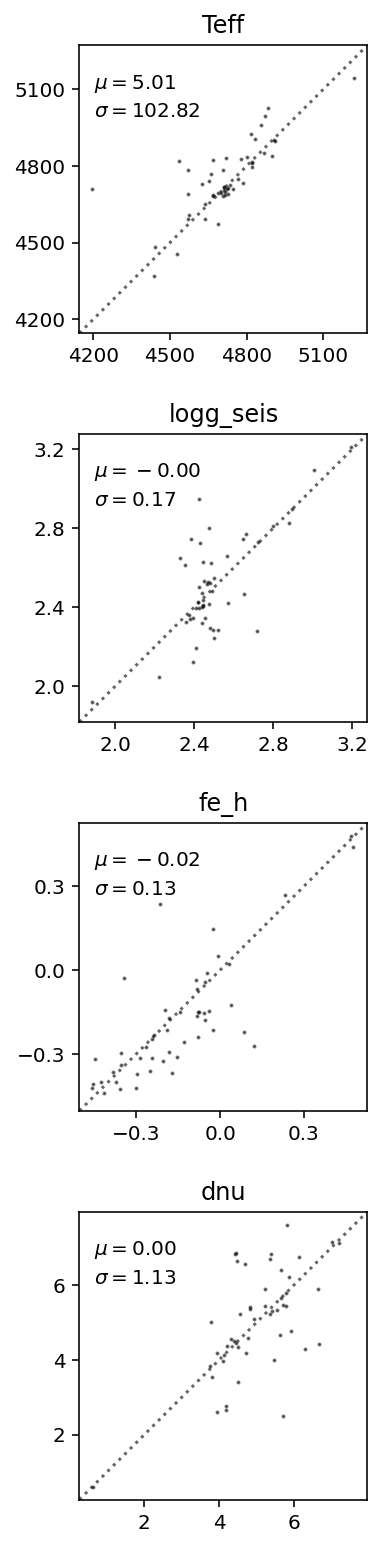

In [157]:
fig_comparison = tc.plot.one_to_one(model, test_labels)

In [158]:
model.vectorizer.get_human_readable_label_vector()

'1 + Teff + logg_seis + fe_h + dnu + Teff^2 + Teff*logg_seis + Teff*fe_h + Teff*dnu + logg_seis^2 + fe_h*logg_seis + dnu*logg_seis + fe_h^2 + dnu*fe_h + dnu^2'

In [159]:
model.is_trained

True

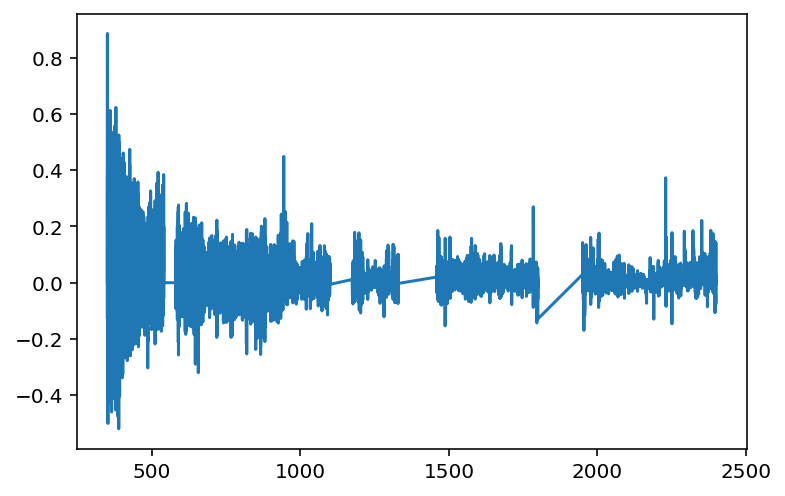

In [160]:
plt.plot(model.dispersion,model.theta[:,1])
# plt.ylim(-0.1,0.4)

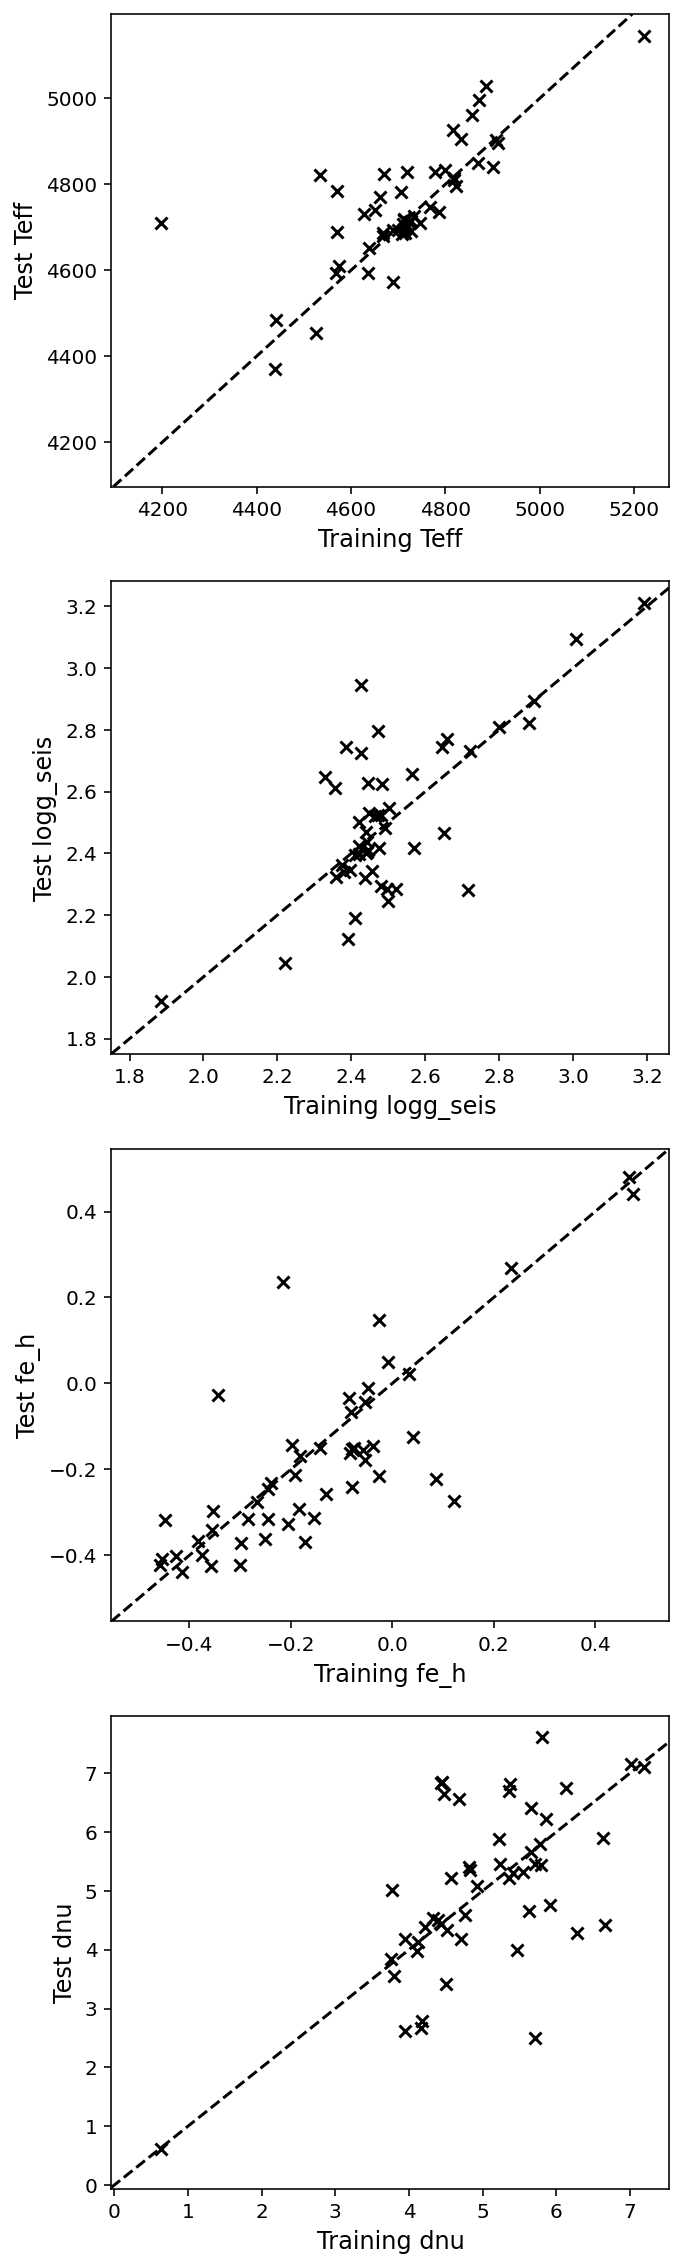

In [162]:
fig, ax = plt.subplots(test_labels.shape[-1],1,figsize=(5,5*test_labels.shape[-1]))

for i in range(test_labels.shape[-1]):
    ax[i].scatter(model.training_set_labels[:,i],test_labels[:,i],marker='x',c='k')
    ax[i].set_xlabel(f'Training {labels[i]}',fontsize=12)
    ax[i].set_ylabel(f'Test {labels[i]}',fontsize=12)
    ax[i].axline((ax[i].get_xlim()[0],ax[i].get_xlim()[0]),(ax[i].get_xlim()[0]+1,ax[i].get_xlim()[0]+1),color='k',linestyle='--')
# ax[0].get_xlim()[0]

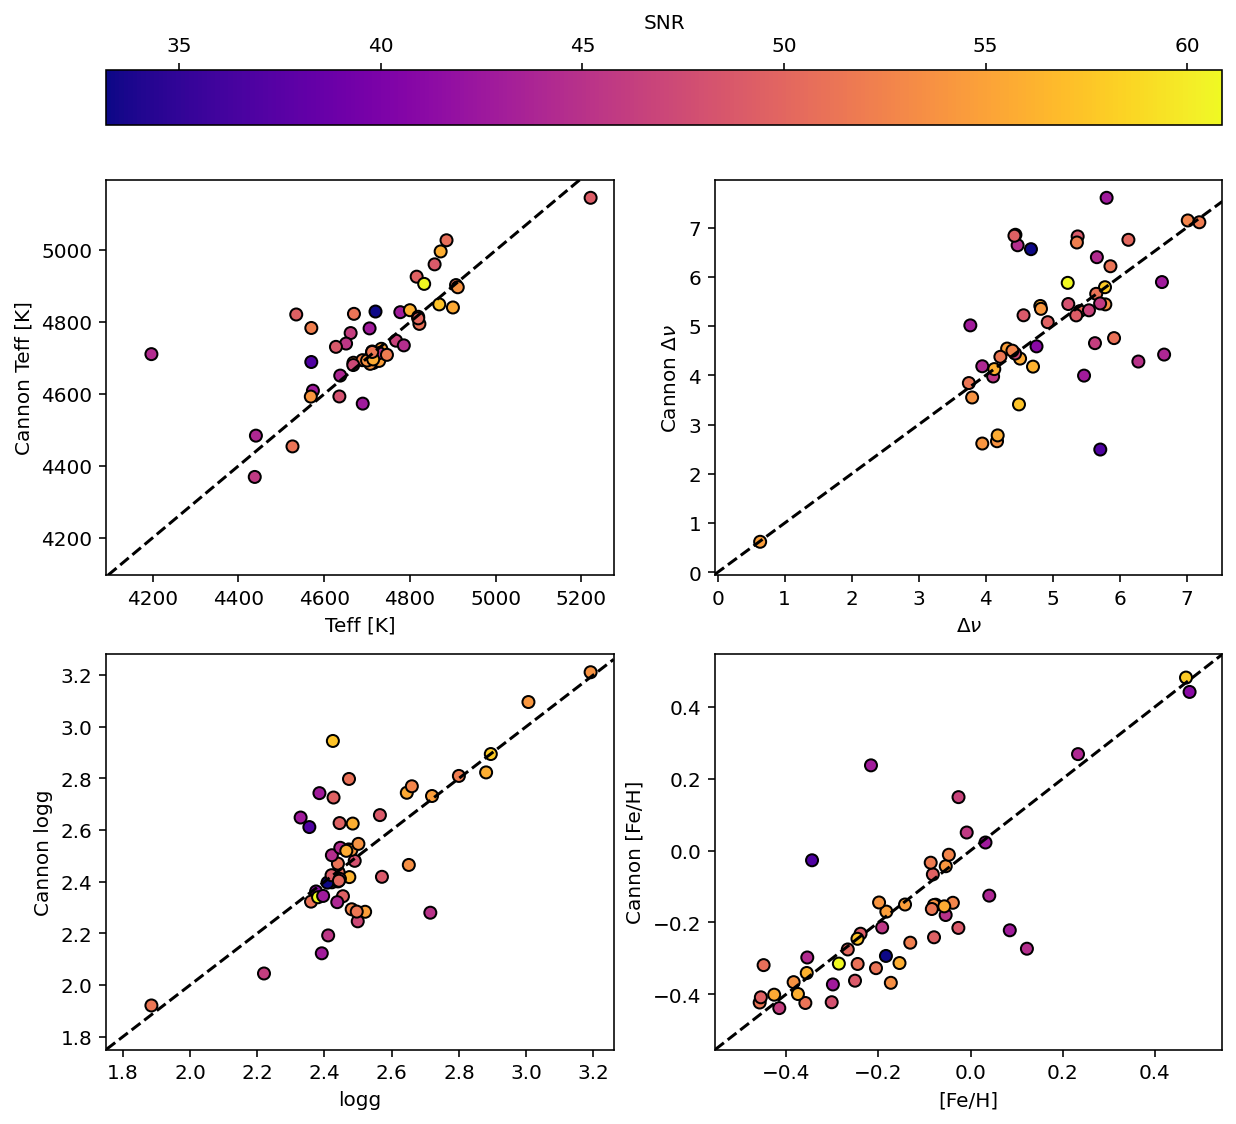

In [221]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

im = ax[0,0].scatter(model.training_set_labels[:,0],test_labels[:,0],c=snr,cmap='plasma',edgecolors='k') # Teff
ax[0,0].axline((ax[0,0].get_xlim()[0],ax[0,0].get_xlim()[0]),(ax[0,0].get_xlim()[0]+1,ax[0,0].get_xlim()[0]+1),color='k',linestyle='--')
ax[0,0].set_xlabel("Teff [K]")
ax[0,0].set_ylabel("Cannon Teff [K]")

ax[0,1].scatter(model.training_set_labels[:,3],test_labels[:,3],c=snr,cmap='plasma',edgecolors='k') # dnu
ax[0,1].axline((ax[0,1].get_xlim()[0],ax[0,1].get_xlim()[0]),(ax[0,1].get_xlim()[0]+1,ax[0,1].get_xlim()[0]+1),color='k',linestyle='--')
ax[0,1].set_xlabel("$\Delta\\nu$")
ax[0,1].set_ylabel("Cannon $\Delta\\nu$")

ax[1,0].scatter(model.training_set_labels[:,1],test_labels[:,1],c=snr,cmap='plasma',edgecolors='k') # logg
ax[1,0].axline((ax[1,0].get_xlim()[0],ax[1,0].get_xlim()[0]),(ax[1,0].get_xlim()[0]+1,ax[1,0].get_xlim()[0]+1),color='k',linestyle='--')
ax[1,0].set_xlabel("logg")
ax[1,0].set_ylabel("Cannon logg")

ax[1,1].scatter(model.training_set_labels[:,2],test_labels[:,2],c=snr,cmap='plasma',edgecolors='k') # [Fe/H]
ax[1,1].axline((ax[1,1].get_xlim()[0],ax[1,1].get_xlim()[0]),(ax[1,1].get_xlim()[0]+1,ax[1,1].get_xlim()[0]+1),color='k',linestyle='--')
ax[1,1].set_xlabel("[Fe/H]")
ax[1,1].set_ylabel("Cannon [Fe/H]")

# cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
# cbar = fig.colorbar(im, cax=cb_ax)

cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=1, location='top')
cbar.set_label("SNR")